In [44]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import norm, skew

from sklearn.linear_model import ElasticNet, Lasso
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from stack_ensemble_learning import StackingAveragedModels
from sklearn.ensemble import StackingRegressor
from utils import *

## Import training set and test set

In [45]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

## Data Processing

In [46]:
test_id = test['Id']
train.drop(columns='Id', inplace=True)
test.drop(columns='Id', inplace=True)
print(train.shape, test.shape, sep='\n')

(1460, 80)
(1459, 79)


### Outliers

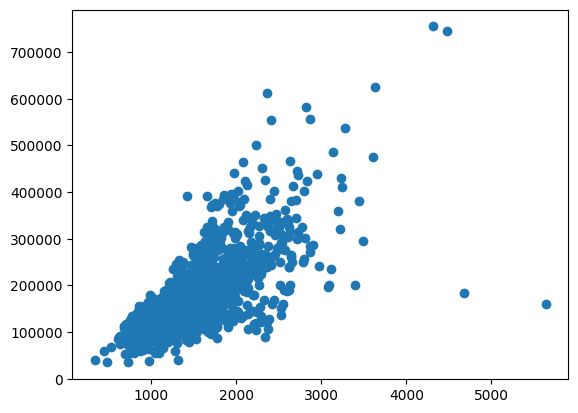

In [47]:
plt.scatter(train.GrLivArea, train.SalePrice)
plt.show()

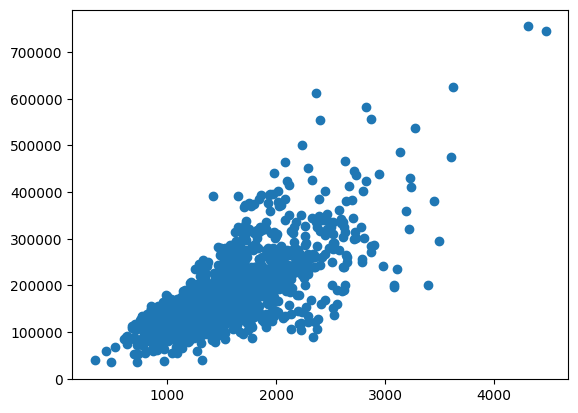

In [48]:
train = train.drop(train[(train.GrLivArea > 4000) & (train.SalePrice < 300000)].index)
plt.scatter(train.GrLivArea, train.SalePrice)
plt.show()

C:\Users\omars\AppData\Local\Temp\ipykernel_5972\44715750.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(train.SalePrice, fit=norm)


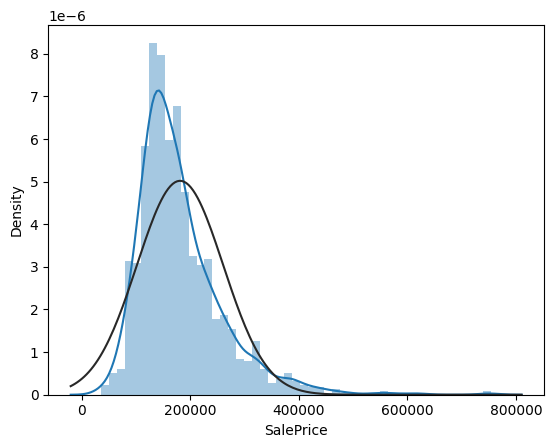

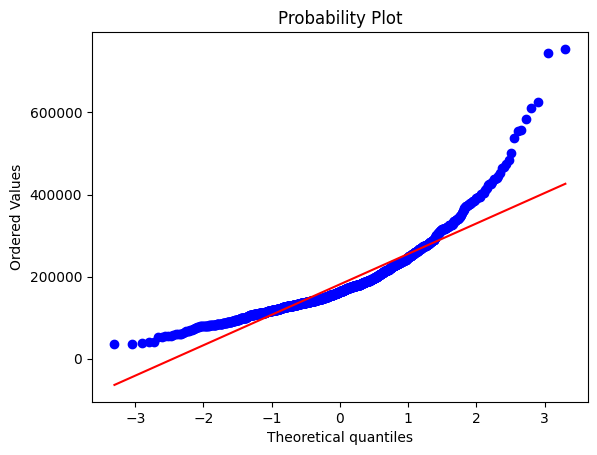

In [49]:
sns.distplot(train.SalePrice, fit=norm)

fig = plt.figure()
res = stats.probplot(train.SalePrice, plot=plt)
plt.show()

C:\Users\omars\AppData\Local\Temp\ipykernel_5972\4041826895.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(train.SalePrice, fit=norm)


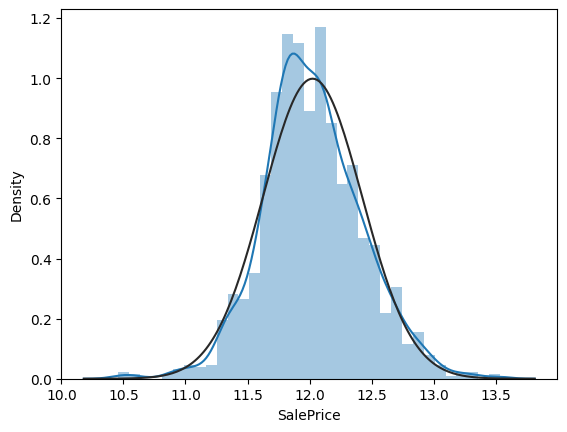

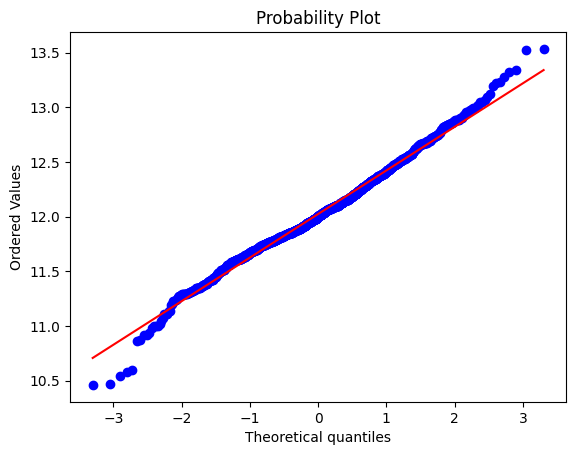

In [50]:
train.SalePrice = np.log1p(train.SalePrice)

sns.distplot(train.SalePrice, fit=norm)

fig = plt.figure()
res = stats.probplot(train.SalePrice, plot=plt)
plt.show()

## Feature Engineering

In [51]:
ntrain = train.shape[0]
ntest = test.shape[0]
y_train = train.SalePrice.values
all_data = pd.concat((train, test)).reset_index(drop=True)
all_data.drop(columns='SalePrice', inplace=True)
all_data.shape

(2917, 79)

### Missing data

In [52]:
all_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2917 entries, 0 to 2916
Data columns (total 79 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     2917 non-null   int64  
 1   MSZoning       2913 non-null   object 
 2   LotFrontage    2431 non-null   float64
 3   LotArea        2917 non-null   int64  
 4   Street         2917 non-null   object 
 5   Alley          198 non-null    object 
 6   LotShape       2917 non-null   object 
 7   LandContour    2917 non-null   object 
 8   Utilities      2915 non-null   object 
 9   LotConfig      2917 non-null   object 
 10  LandSlope      2917 non-null   object 
 11  Neighborhood   2917 non-null   object 
 12  Condition1     2917 non-null   object 
 13  Condition2     2917 non-null   object 
 14  BldgType       2917 non-null   object 
 15  HouseStyle     2917 non-null   object 
 16  OverallQual    2917 non-null   int64  
 17  OverallCond    2917 non-null   int64  
 18  YearBuil

In [53]:
all_data_na = (all_data.isnull().sum() / len(all_data)) * 100
all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending=False)
missing_data = pd.DataFrame({'Missing percentage': all_data_na})
missing_data.head(50)

,Missing percentage
PoolQC,99.691464
MiscFeature,96.400411
Alley,93.212204
Fence,80.425094
MasVnrType,60.541652
FireplaceQu,48.680151
LotFrontage,16.660953
GarageFinish,5.450806
GarageQual,5.450806
GarageCond,5.450806


<Axes: >

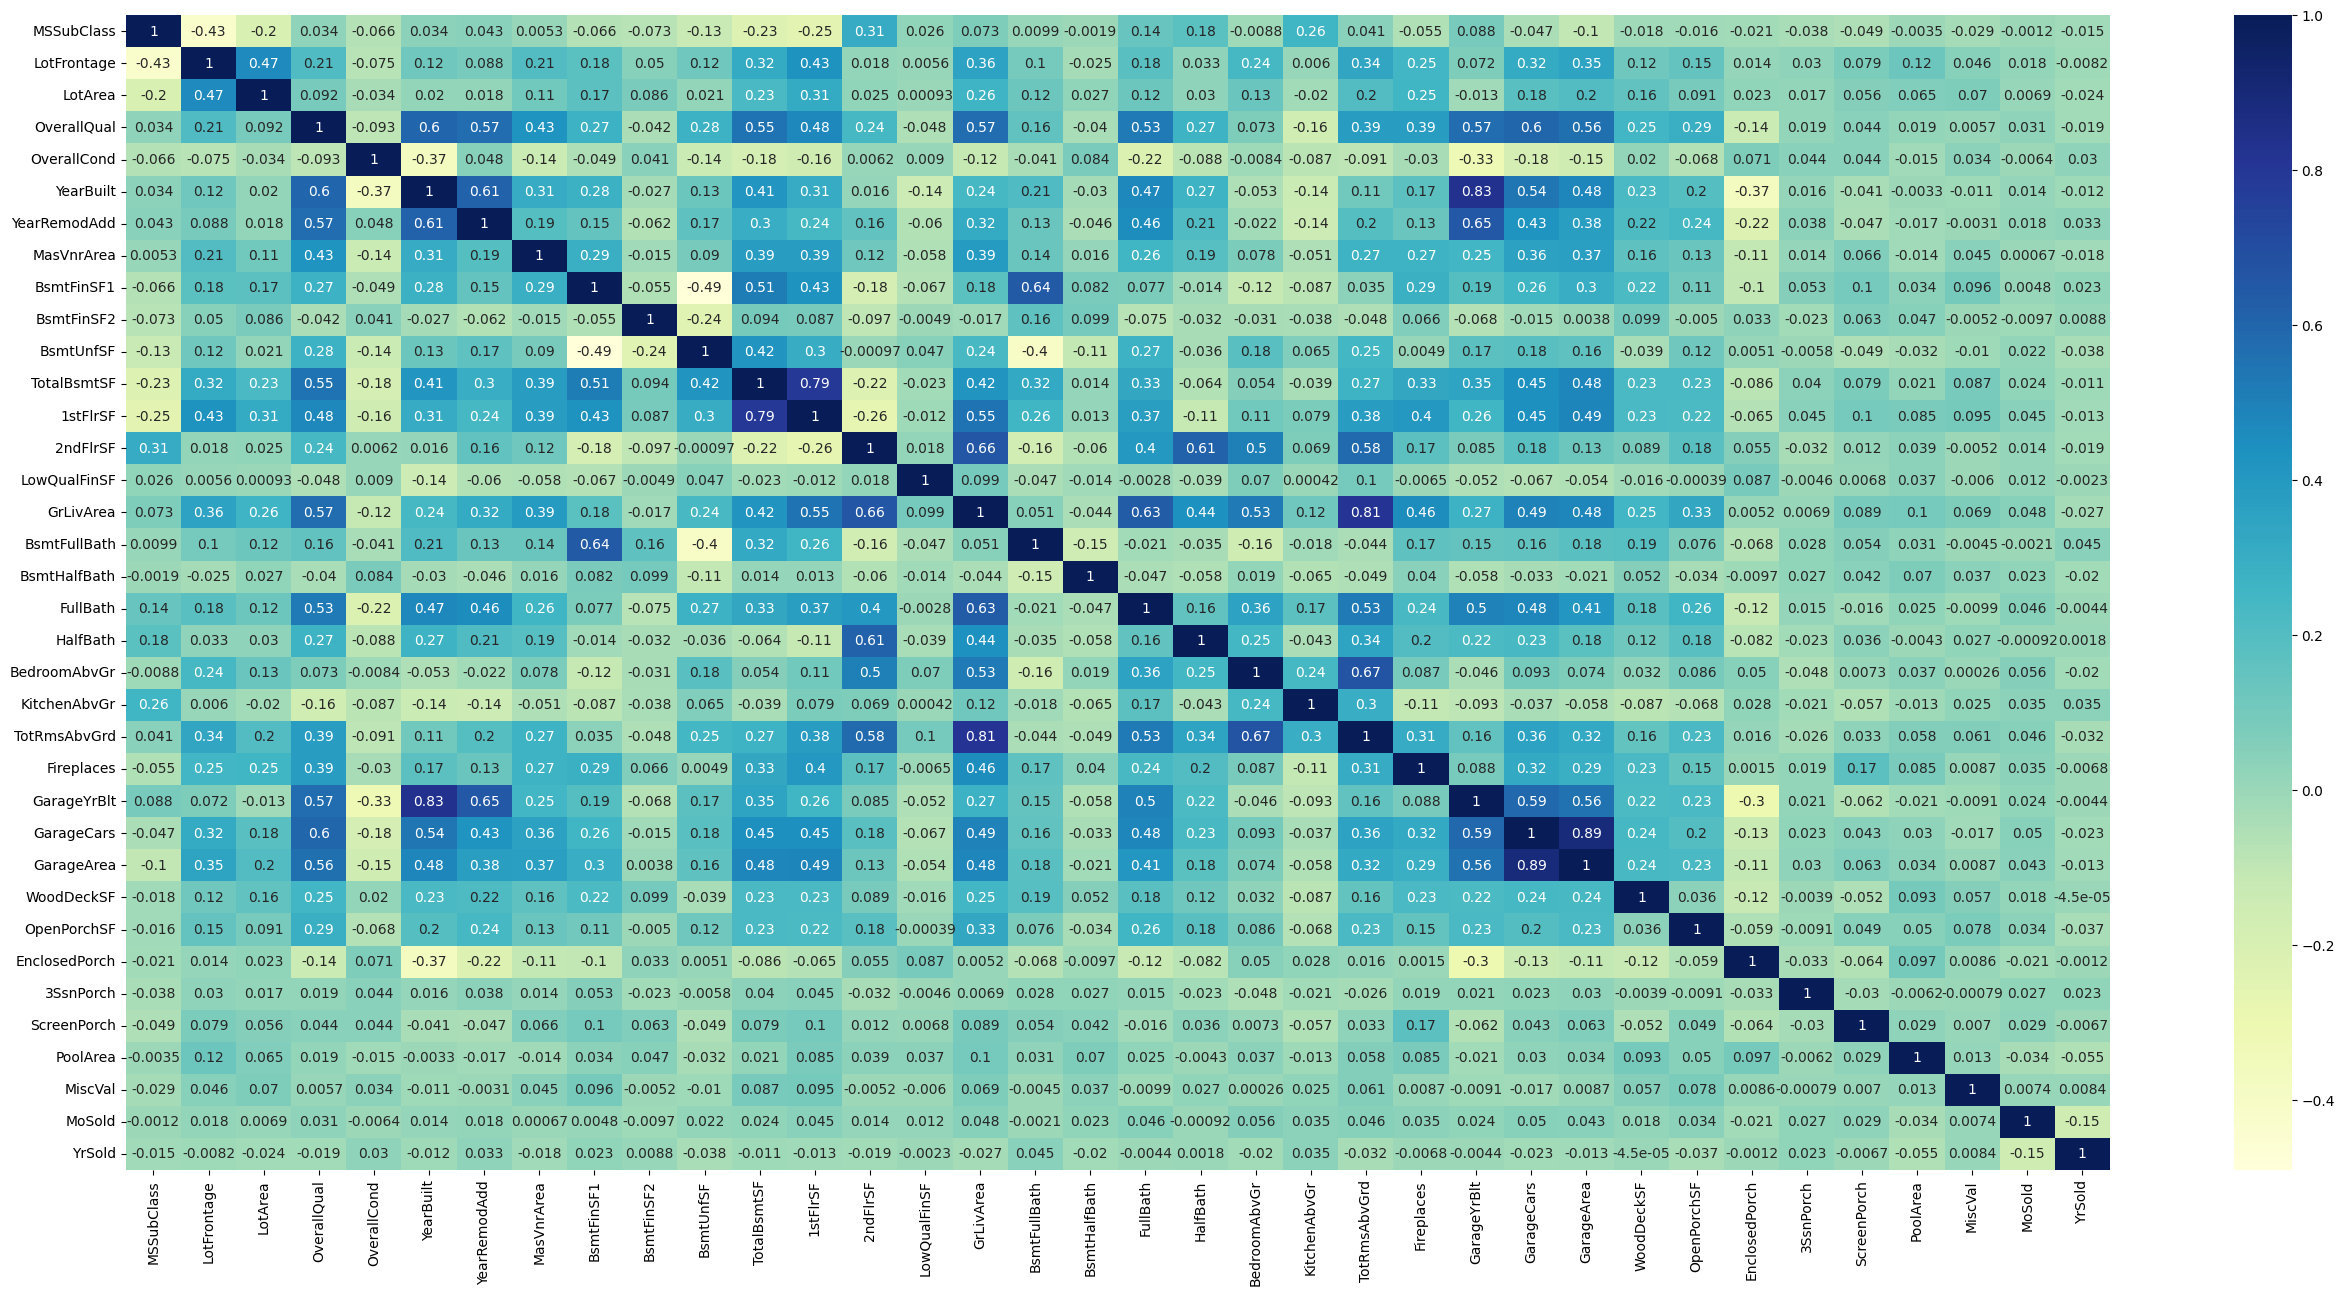

In [54]:
cols = all_data.dtypes[all_data.dtypes != 'object'].index
cmap_data = pd.DataFrame(all_data[cols])

corrmat = cmap_data.corr()
plt.subplots(figsize=(32,15))
sns.heatmap(corrmat, color="k", annot=True, cmap="YlGnBu",)

### Imputing missing values

In [55]:
cols = ['PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu', 'Utilities']
all_data.drop(columns=cols, inplace = True)

In [56]:
all_data.LotFrontage = all_data.groupby('Neighborhood')['LotFrontage'].transform(lambda x: x.fillna(x.median()))

In [57]:
cols = ['GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'BsmtQual', 
        'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'MasVnrType', 'MSZoning', 
        'Electrical', 'KitchenQual', 'Exterior1st', 'Exterior2nd', 'SaleType', 'MSSubClass']
for col in cols:
    all_data[col] = all_data[col].fillna(all_data[col].mode()[0])

In [58]:
cols = ['GarageYrBlt', 'GarageArea', 'GarageCars', 'BsmtFinSF1', 'MasVnrArea',
        'BsmtFinSF2', 'BsmtUnfSF','TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath']
for col in cols:
    all_data[col] = all_data[col].fillna(all_data[col].mean())

In [59]:
all_data["Functional"] = all_data["Functional"].fillna("Typ")

In [60]:
all_data_na = (all_data.isnull().sum() / len(all_data)) * 100
all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending=False)
missing_data = pd.DataFrame({'Missing percentage' :all_data_na})
missing_data.head()

,Missing percentage


### Transforming some numerical features to categorical

In [61]:
all_data.MSSubClass = all_data.MSSubClass.apply(str)
all_data.YrSold = all_data.YrSold.astype(str)
all_data.MoSold = all_data.MoSold.astype(str)
all_data.OverallCond = all_data.OverallCond.astype(str)

### Label Encoding

In [62]:
from sklearn.preprocessing import LabelEncoder 
cols = ('BsmtQual', 'BsmtCond', 'GarageQual', 'GarageCond',
        'ExterQual', 'ExterCond','HeatingQC', 'KitchenQual', 'BsmtFinType1',
        'BsmtFinType2', 'Functional', 'BsmtExposure', 'GarageFinish', 'LandSlope',
        'LotShape', 'PavedDrive', 'Street' , 'CentralAir', 'MSSubClass', 'OverallCond',
        'YrSold', 'MoSold')


for c in cols:
    lbl = LabelEncoder()
    all_data[c] = lbl.fit_transform(list(all_data[c].values))


print(f'Shape all_data: {all_data.shape}')

Shape all_data: (2917, 73)


### Creating new feature

In [63]:
all_data['TotalSF'] = all_data['TotalBsmtSF'] + all_data['1stFlrSF'] + all_data['2ndFlrSF']

### Skewed features

In [64]:
numeric_features = all_data.dtypes[all_data.dtypes != 'object'].index

skewed_features = all_data[numeric_features].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
skewed_data = pd.DataFrame({'Skew': skewed_features})
skewed_data.head(10)

,Skew
MiscVal,21.939672
PoolArea,17.688664
LotArea,13.109495
LowQualFinSF,12.084539
3SsnPorch,11.372080
LandSlope,4.973254
KitchenAbvGr,4.300550
BsmtFinSF2,4.144394
EnclosedPorch,4.002344
ScreenPorch,3.945101


In [65]:
skewed_data = skewed_data[abs(skewed_data) > 0.75]

from scipy.special import boxcox1p

skewed_index = skewed_data.index
for idx in skewed_index:
    all_data[idx] = boxcox1p(all_data[idx], 0.15)

all_data[skewed_index] = np.log1p(all_data[skewed_index])

In [66]:
numeric_features = all_data.dtypes[all_data.dtypes != 'object'].index

skewed_features = all_data[numeric_features].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
skewed_data = pd.DataFrame({'Skew': skewed_features})
skewed_data.head(10)

,Skew
PoolArea,15.541774
3SsnPorch,8.753475
LowQualFinSF,8.434002
MiscVal,5.090434
LandSlope,4.359960
BsmtHalfBath,3.739810
ScreenPorch,2.924605
KitchenAbvGr,2.528941
BsmtFinSF2,2.391191
EnclosedPorch,1.911952


#### Getting the dummy categorical features

In [67]:
all_data = pd.get_dummies(all_data)
all_data.shape

(2917, 209)

#### Getting the new train set and test set

In [68]:
train = all_data[:ntrain]
test = all_data[ntrain:]
train.shape

(1458, 209)

## Modeling

### Base Models

In [69]:
lasso = make_pipeline(RobustScaler(), Lasso(alpha=0.0005, random_state=1))

In [70]:
ENet = make_pipeline(RobustScaler(), ElasticNet(alpha=0.0005, l1_ratio=0.9, random_state=3))

In [71]:
KRR = KernelRidge(alpha=0.6, kernel='polynomial', degree=2, coef0=2.5)

In [72]:
GBoost = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05,
                                   max_depth=4, max_features='sqrt',
                                   min_samples_leaf=15, min_samples_split=10,
                                   loss='huber', random_state=5)

In [73]:
model_xgb = XGBRegressor(colsample_bytree=0.4603, gamma=0.0468,
                             learning_rate=0.05, max_depth=3,
                             min_child_weight=1.7817, n_estimators=2200,
                             reg_alpha=0.4640, reg_lambda=0.8571,
                             subsample=0.5213, silent=1,
                             random_state=7, nthread=-1)

In [74]:
model_lgb = LGBMRegressor(objective='regression',num_leaves=5,
                              learning_rate=0.05, n_estimators=720,
                              max_bin = 55, bagging_fraction = 0.8,
                              bagging_freq = 5, feature_fraction = 0.2319,
                              feature_fraction_seed=9, bagging_seed=9,
                              min_data_in_leaf=6, min_sum_hessian_in_leaf=11)

### Base Models Scores

In [ ]:
rmse_cv_score = rmse_cv(ENet, train, y_train)
print(f"ENet Score: {rmse_cv_score.mean():.4f}")

ENet Score: 0.1146


In [ ]:
rmse_cv_score = rmse_cv(lasso, train, y_train)
print(f"Lasso Score: {rmse_cv_score.mean():.4f}")

Lasso Score: 0.1147


In [ ]:
rmse_cv_score = rmse_cv(KRR, train, y_train)
print(f"KRR Score: {rmse_cv_score.mean():.4f}")

KRR Score: 0.1428


In [ ]:
rmse_cv_score = rmse_cv(GBoost, train, y_train)
print(f"GBoost Score: {rmse_cv_score.mean():.4f}")

GBoost Score: 0.1166


In [ ]:
rmse_cv_score = rmse_cv(model_xgb, train, y_train)
print(f"model_xgb Score: {rmse_cv_score.mean():.4f}")

[11:57:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "silent" } are not used.

[11:57:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "silent" } are not used.

[11:57:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "silent" } are not used.

[11:57:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "silent" } are not used.

[11:57:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "silent" } are not used.

model_xgb Score: 0.1

In [ ]:
rmse_cv_score = rmse_cv(model_lgb, train, y_train)
print(f"model_lgb Score: {rmse_cv_score.mean():.4f}")

[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] feature_fraction is set=0.2319, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2319
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] feature_fraction is set=0.2319, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2319
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11

### **Stacking Averaged Models**

In [ ]:
stacked_averaged_model = StackingAveragedModels(base_models=(lasso, GBoost, KRR), meta_model=ENet)
rmse_cv_score = rmse_cv(stacked_averaged_model, train, y_train)
print(f"Stacking Averaged Models score: {rmse_cv_score.mean():.4f}")

KeyboardInterrupt: 

## Training and Prediction

In [ ]:
stacked_averaged_model.fit(train.values, y_train)
stack_train_pred = stacked_averaged_model.predict(train.values)
stacked_pred = np.expm1(stacked_averaged_model.predict(test.values))
rmse(y_train, stack_train_pred)

In [ ]:
model_lgb.fit(train, y_train)
lgb_train_pred = model_lgb.predict(train.values)
lgb_pred = np.expm1(model_lgb.predict(test.values))
rmse(y_train, lgb_train_pred)

[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] feature_fraction is set=0.2319, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2319
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] feature_fraction is set=0.2319, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2319
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, m

In [ ]:
model_xgb.fit(train, y_train)
xgb_train_pred = model_xgb.predict(train)
xgb_pred = np.expm1(model_xgb.predict(test))
rmse(y_train, xgb_train_pred)

[11:50:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "silent" } are not used.



### Finding the best scores for ensemble

In [ ]:
from sys import maxsize

best_score = [maxsize, -1, -1, -1]

for stack_i in np.arange(0.1, 0.99, 0.05):
    for lgb_i in np.arange(0.1, 0.99, 0.05):
        for xgb_i in np.arange(0.1, 0.99, 0.05):
            rmse_score = rmse(y_train, stack_train_pred * stack_i + lgb_train_pred * lgb_i + xgb_train_pred * xgb_i)
            if (0 <= rmse_score < best_score[0]) and stack_i > 0.7 and lgb_i > 0.1 and xgb_i > 0.1:
                best_score[0] = rmse_score
                best_score[1] = stack_i
                best_score[2] = lgb_i
                best_score[3] = xgb_i


In [ ]:
best_score

In [ ]:
ensemble = stacked_pred * 0.7 + lgb_pred * 0.15 + xgb_pred * 0.15

### Submission

In [ ]:
final_submission = pd.DataFrame()
final_submission['Id'] = test_id
final_submission['SalePrice'] = ensemble
final_submission.to_csv('submission3.csv', index=False)